# Keras Segmentation Models
In this kernel, we learn how to install and use pretrained Keras segmentation models from GitHub [here][1] with docs [here][2]. We also plot EDA showing training examples, UNET prediction examples, and UNET error.

# Data Generator
First let's restructure the train.csv dataframe and build a data generator. We will need to feed our neural network `X_train` of images and `y_train` of masks. We will resize all images by a factor of 0.5 for efficiency. (Convert 256x1600 RGB to 128x800 RGB).

[1]: https://github.com/qubvel/segmentation_models
[2]: https://segmentation-models.readthedocs.io/en/latest/tutorial.html

In [1]:
import numpy as np, pandas as pd, os, gc
import matplotlib.pyplot as plt, time
from PIL import Image 
import warnings
warnings.filterwarnings("ignore")

path = '../input/'
train = pd.read_csv(path + 'train.csv')

# RESTRUCTURE TRAIN DATAFRAME
train3 = train.pivot(index='ImageId', columns='ClassId', values='EncodedPixels')
train3.columns=['e1','e2','e3','e4']#创造列名
#重构 dataframe  可以用一个新的train3
train2=pd.DataFrame({'ImageId':list(train3.index),'e1':list(train3['e1']),'e2':list(train3['e2']),'e3':list(train3['e3']),'e4':list(train3['e4'])})
train2.fillna('',inplace=True)#将无效值nan转化为' '（空格）
train2['count'] = np.sum(train2.iloc[:,1:]!='',axis=1).values#对列值数据进行统计
train2.head()

ImageId                                                 e1 e2  \
0  0002cc93b.jpg  29102 12 29346 24 29602 24 29858 24 30114 24 3...      
1  0007a71bf.jpg                                                         
2  000a4bcdd.jpg  37607 3 37858 8 38108 14 38359 20 38610 25 388...      
3  000f6bf48.jpg                                                         
4  0014fce06.jpg                                                         

                                                  e3  \
0                                                      
1  18661 28 18863 82 19091 110 19347 110 19603 11...   
2                                                      
3                                                      
4  229501 11 229741 33 229981 55 230221 77 230468...   

                                                  e4  count  
0                                                         1  
1                                                         1  
2                                                         1  
3  131973 1 132228 4 132483 6 132738 8 132993 11 ...      1  
4                                                         1

In [2]:
# https://www.kaggle.com/ateplyuk/pytorch-starter-u-net-resnet
# https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
import keras

class DataGenerator(keras.utils.Sequence):
    def __init__(self, df, batch_size = 16, subset="train", shuffle=False, 
                 preprocess=None, info={}):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        self.preprocess = preprocess
        self.info = info
        
        if self.subset == "train":
            self.data_path = path + 'train_images/'
        elif self.subset == "test":
            self.data_path = path + 'test_images/'
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.df) / self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index): 
        X = np.empty((self.batch_size,128,800,3),dtype=np.float32)
        y = np.empty((self.batch_size,128,800,4),dtype=np.int8)
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.df['ImageId'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = Image.open(self.data_path + f).resize((800,128))
            if self.subset == 'train': 
                for j in range(4):
                    y[i,:,:,j] = rle2maskResize(self.df['e'+str(j+1)].iloc[indexes[i]])
        if self.preprocess!=None: X = self.preprocess(X)
        if self.subset == 'train': return X, y
        else: return X

Using TensorFlow backend.


# Utility Functions
Next we'll need some utility functions. The first converts rle to mask. The second converts a mask to its contour. The third enlarges a mask. The second and third together put blank space between defect and mask contour for better visualization.

In [3]:
# https://www.kaggle.com/titericz/building-and-visualizing-masks
def rle2maskResize(rle):
    # CONVERT RLE TO MASK 
    if (pd.isnull(rle))|(rle==''): 
        return np.zeros((128,800) ,dtype=np.uint8)
    
    height= 256
    width = 1600
    mask= np.zeros( width*height ,dtype=np.uint8)

    array = np.asarray([int(x) for x in rle.split()])
    starts = array[0::2]-1
    lengths = array[1::2]    
    for index, start in enumerate(starts):
        mask[int(start):int(start+lengths[index])] = 1
    
    return mask.reshape( (height,width), order='F' )[::2,::2]

def mask2contour(mask, width=3):
    # CONVERT MASK TO ITS CONTOUR
    w = mask.shape[1]
    h = mask.shape[0]
    mask2 = np.concatenate([mask[:,width:],np.zeros((h,width))],axis=1)
    mask2 = np.logical_xor(mask,mask2)
    mask3 = np.concatenate([mask[width:,:],np.zeros((width,w))],axis=0)
    mask3 = np.logical_xor(mask,mask3)
    return np.logical_or(mask2,mask3) 

def mask2pad(mask, pad=2):
    # ENLARGE MASK TO INCLUDE MORE SPACE AROUND DEFECT
    w = mask.shape[1]
    h = mask.shape[0]
    
    # MASK UP
    for k in range(1,pad,2):
        temp = np.concatenate([mask[k:,:],np.zeros((k,w))],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK DOWN
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((k,w)),mask[:-k,:]],axis=0)
        mask = np.logical_or(mask,temp)
    # MASK LEFT
    for k in range(1,pad,2):
        temp = np.concatenate([mask[:,k:],np.zeros((h,k))],axis=1)
        mask = np.logical_or(mask,temp)
    # MASK RIGHT
    for k in range(1,pad,2):
        temp = np.concatenate([np.zeros((h,k)),mask[:,:-k]],axis=1)
        mask = np.logical_or(mask,temp)
    
    return mask 

# Train EDA
Let's confirm our Data Generator works and view some training images. We will only show examples with defects. Note that all mask contours are plotted with a little blank space around the defect to aid visualization. Below we show examples of each type but note that in the training set only 7.1%, 2.0%, 41.0%, 6.4% of images have defects 1, 2, 3, 4 respectively.

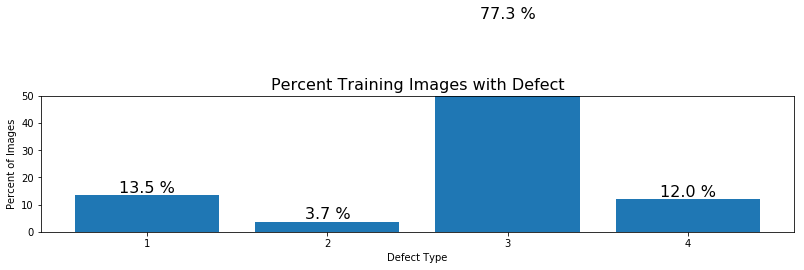

In [4]:
plt.figure(figsize=(13.5,2.5))
bar = plt.bar( [1,2,3,4],100*np.mean( train2.iloc[:,1:5]!='',axis=0) )
plt.title('Percent Training Images with Defect', fontsize=16)
plt.ylabel('Percent of Images'); plt.xlabel('Defect Type')
plt.xticks([1,2,3,4])
for rect in bar:
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, '%.1f %%' % height,
             ha='center', va='bottom',fontsize=16)
plt.ylim((0,50)); plt.show()

Images and masks from our Data Generator
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


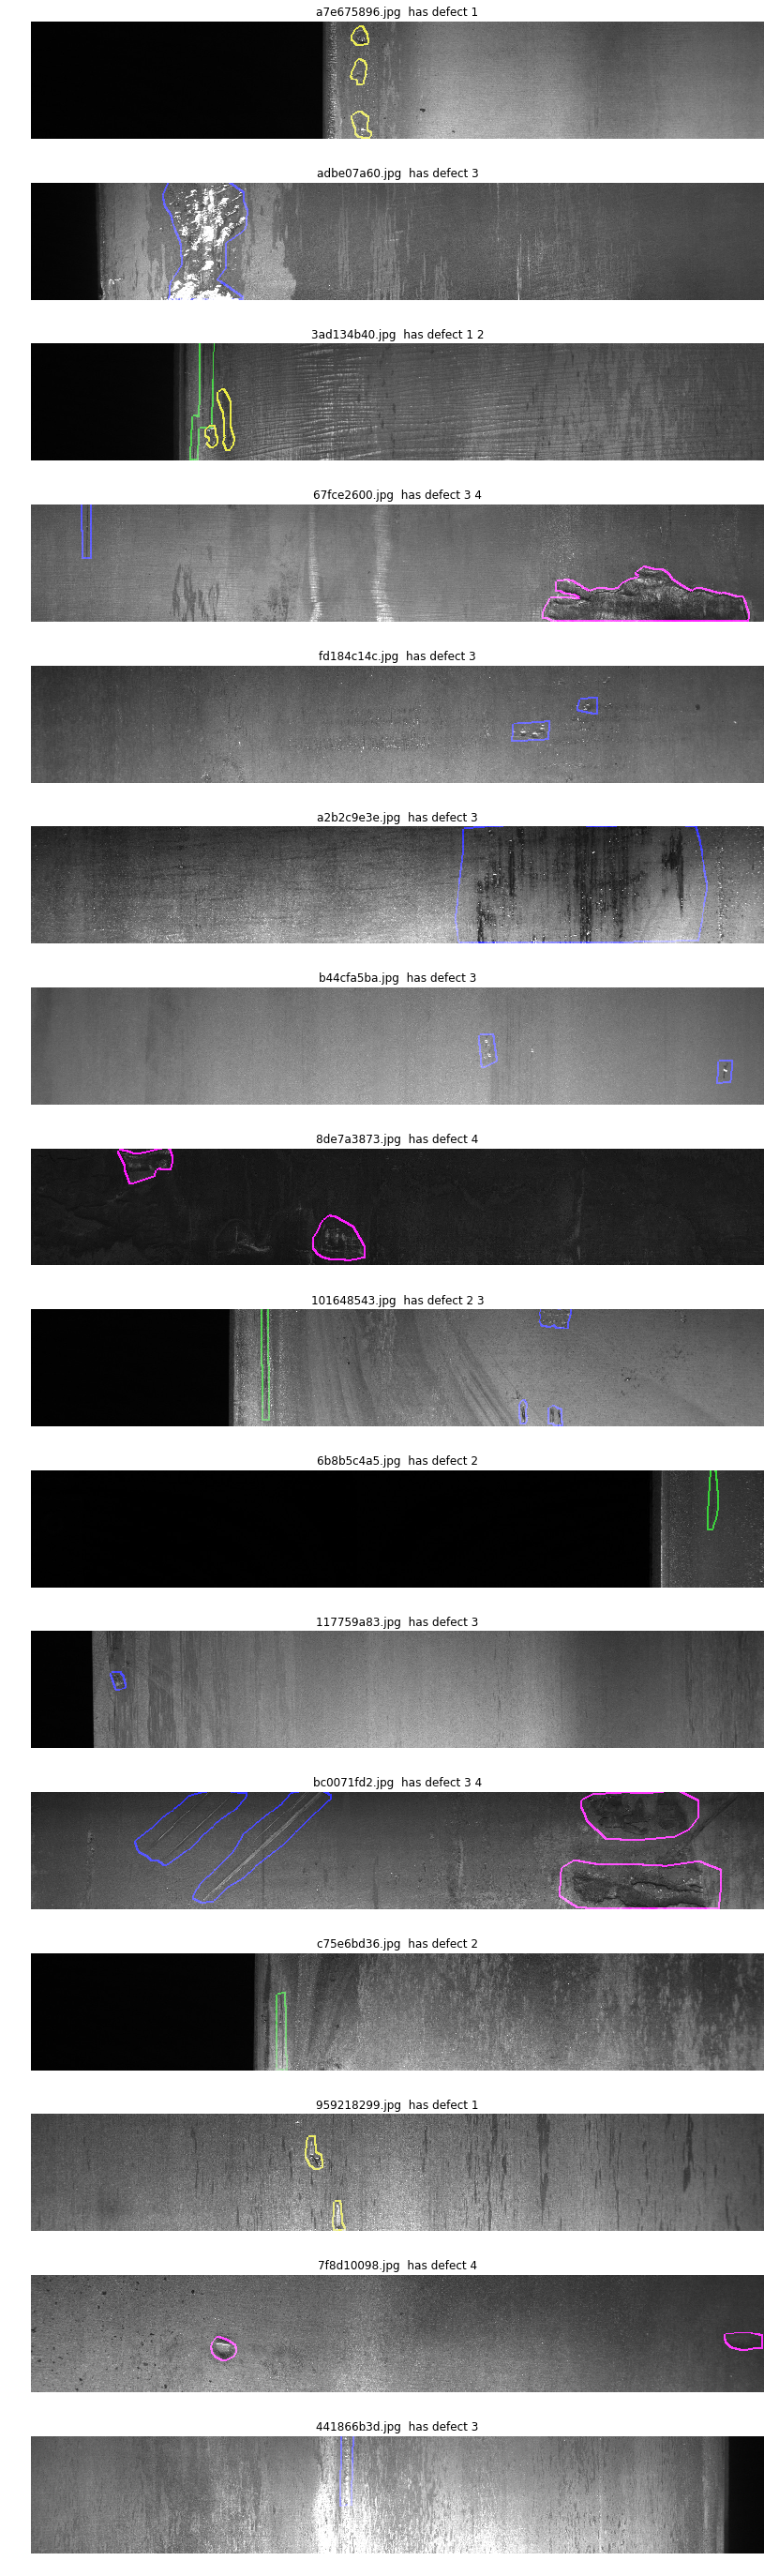

In [5]:
# DEFECTIVE IMAGE SAMPLES
filenames = {}
defects = list(train2[train2['e1']!=''].sample(3).index)
defects += list(train2[train2['e2']!=''].sample(3).index)
defects += list(train2[train2['e3']!=''].sample(7).index)
defects += list(train2[train2['e4']!=''].sample(3).index)

# DATA GENERATOR
train_batches = DataGenerator(train2[train2.index.isin(defects)],shuffle=True,info=filenames)
print('Images and masks from our Data Generator')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

# DISPLAY IMAGES WITH DEFECTS
for i,batch in enumerate(train_batches):
    plt.figure(figsize=(14,50)) #20,18
    for k in range(16):
        plt.subplot(16,1,k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        extra = '  has defect'
        for j in range(4):
            msk = batch[1][k,:,:,j]
            msk = mask2pad(msk,pad=3)
            msk = mask2contour(msk,width=2)
            if np.sum(msk)!=0: extra += ' '+str(j+1)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        plt.title(filenames[16*i+k]+extra)
        plt.axis('off') 
        plt.imshow(img)
    plt.subplots_adjust(wspace=0.05)
    plt.show()

# Download UNET
We will download a pretrained Keras UNET from GitHub [here][1] with docs [here][2]. In this repository, there are many different architectures and pretrained backbones. Although the bottom is pretrained, the top of the model needs to be trained to our data. We will train for 90 minutes. To use this model in Kaggle's Steel competition, we'll need to save this trained model to a Kaggle dataset and load it into another kernel (called an inference kernel). The second kernel will make predictions on the test set. We can submit this second kernel because it will execute under an hour and have internet turned off thus satifying the comp rules.

[1]: https://github.com/qubvel/segmentation_models
[2]: https://segmentation-models.readthedocs.io/en/latest/tutorial.html

In [6]:
! pip install segmentation-models

You should consider upgrading via the 'pip install --upgrade pip' command.


In [7]:
from keras import backend as K
# https://www.kaggle.com/xhlulu/severstal-simple-keras-u-net-boilerplate

# COMPETITION METRIC
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [8]:
import  segmentation_models as sm
from segmentation_models import Unet
#from segmentation_models.backbones import get_preprocessing

# LOAD UNET WITH PRETRAINING FROM IMAGENET
BACKBONE='resnet34'
preprocess = sm.get_preprocessing(BACKBONE) # for resnet, img = (img-110.0)/1.0
model = Unet('resnet34', input_shape=(128, 800, 3), classes=4, activation='sigmoid')
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])

# TRAIN AND VALIDATE MODEL
idx = int(0.8*len(train2)); print()
train_batches = DataGenerator(train2.iloc[:idx],shuffle=True,preprocess=preprocess)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)
history = model.fit_generator(train_batches, validation_data = valid_batches, epochs = 30, verbose=2)

Segmentation Models: using `keras` framework.
85524480/85521592 [==============================] - 4s 0us/step

Epoch 1/30
 - 123s - loss: 0.0888 - dice_coef: 0.2319 - val_loss: 0.0459 - val_dice_coef: 0.3121
Epoch 2/30
 - 102s - loss: 0.0318 - dice_coef: 0.4179 - val_loss: 0.0388 - val_dice_coef: 0.4508
Epoch 3/30
 - 101s - loss: 0.0291 - dice_coef: 0.4642 - val_loss: 0.0404 - val_dice_coef: 0.4718
Epoch 4/30
 - 101s - loss: 0.0281 - dice_coef: 0.4842 - val_loss: 0.1920 - val_dice_coef: 0.2045
Epoch 5/30
 - 101s - loss: 0.0262 - dice_coef: 0.5169 - val_loss: 0.0272 - val_dice_coef: 0.5428
Epoch 6/30
 - 101s - loss: 0.0236 - dice_coef: 0.5534 - val_loss: 0.0238 - val_dice_coef: 0.5623
Epoch 7/30
 - 102s - loss: 0.0240 - dice_coef: 0.5479 - val_loss: 0.0238 - val_dice_coef: 0.5457
Epoch 8/30
 - 102s - loss: 0.0224 - dice_coef: 0.5716 - val_loss: 0.0246 - val_dice_coef: 0.5674
Epoch 9/30
 - 101s - loss: 0.0216 - dice_coef: 0.5863 - val_loss: 0.0239 - val_dice_coef: 0.5695
Epoch 10/30
 - 

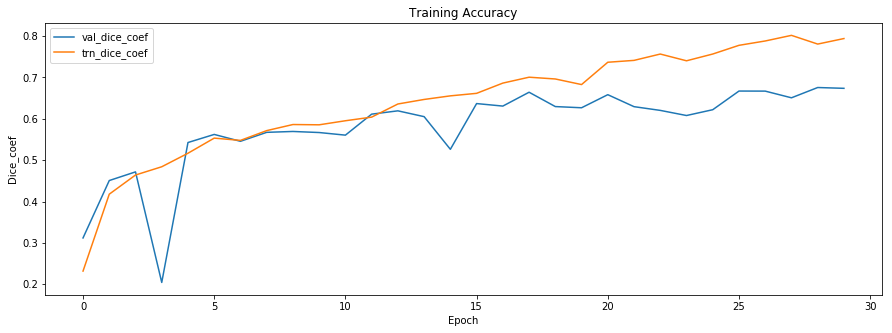

In [9]:
# PLOT TRAINING
plt.figure(figsize=(15,5))
plt.plot(range(history.epoch[-1]+1),history.history['val_dice_coef'],label='val_dice_coef')
plt.plot(range(history.epoch[-1]+1),history.history['dice_coef'],label='trn_dice_coef')
plt.title('Training Accuracy'); plt.xlabel('Epoch'); plt.ylabel('Dice_coef');plt.legend(); 
plt.show()

# Prediction EDA
In the images below (which all contain defects), we will display one prediction mask for a defect that is present. Note that `matplotlib` scales the mask's largest pixel value to yellow and smallest to blue. Therefore the presense of yellow doesn't indicate that the mask achieved a pixel value 1.0. The maximum pixel value is indicated in the titles and is a measure of mask confidence.

In [10]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS)
val_set = train2.iloc[idx:];
defects = list(val_set[val_set['e1']!=''].sample(6).index)
defects += list(val_set[val_set['e2']!=''].sample(6).index)
defects += list(val_set[val_set['e3']!=''].sample(14).index)
defects += list(val_set[val_set['e4']!=''].sample(6).index)

valid_batches = DataGenerator(val_set[val_set.index.isin(defects)],preprocess=preprocess)
preds = model.predict_generator(valid_batches,verbose=1)

2/2 [==============================] - 2s 759ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


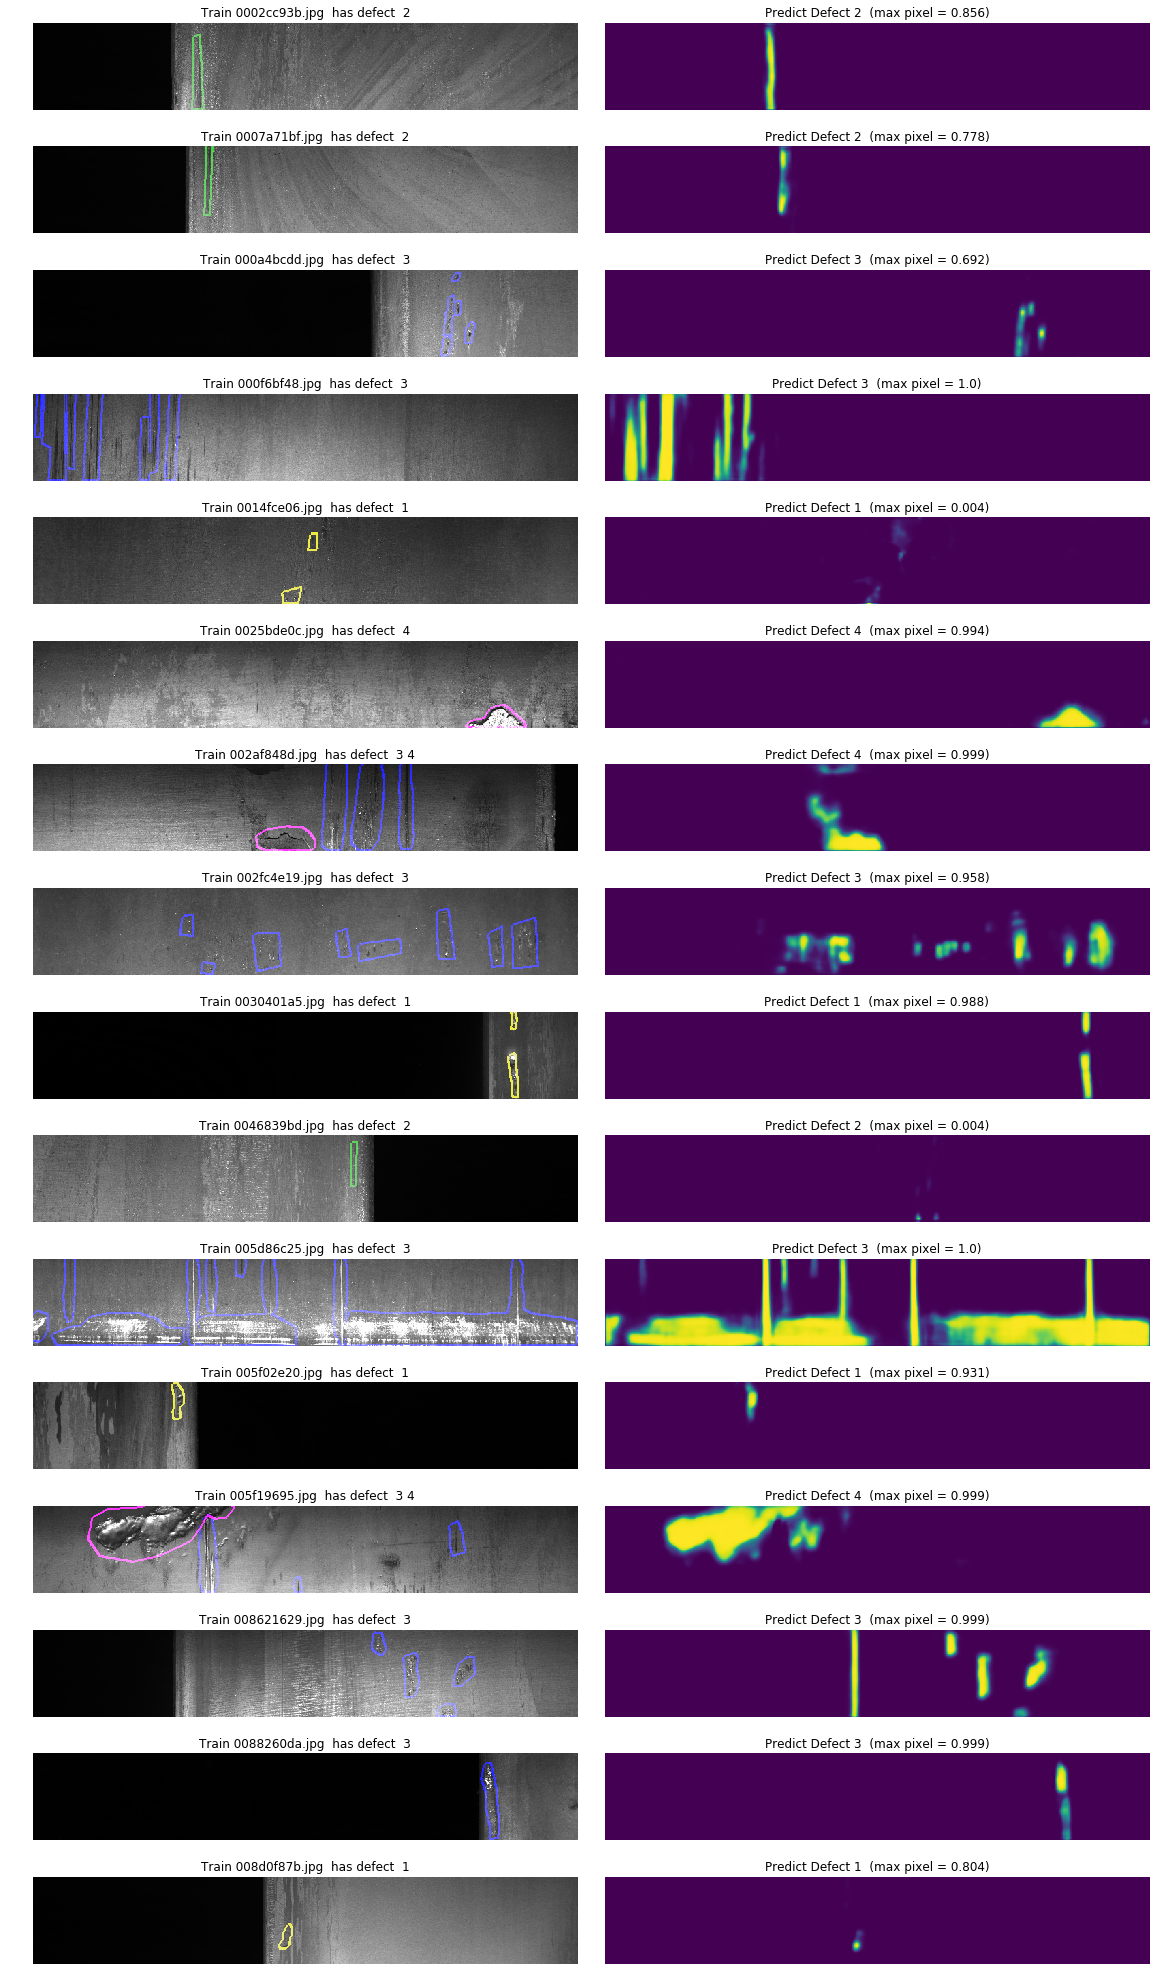

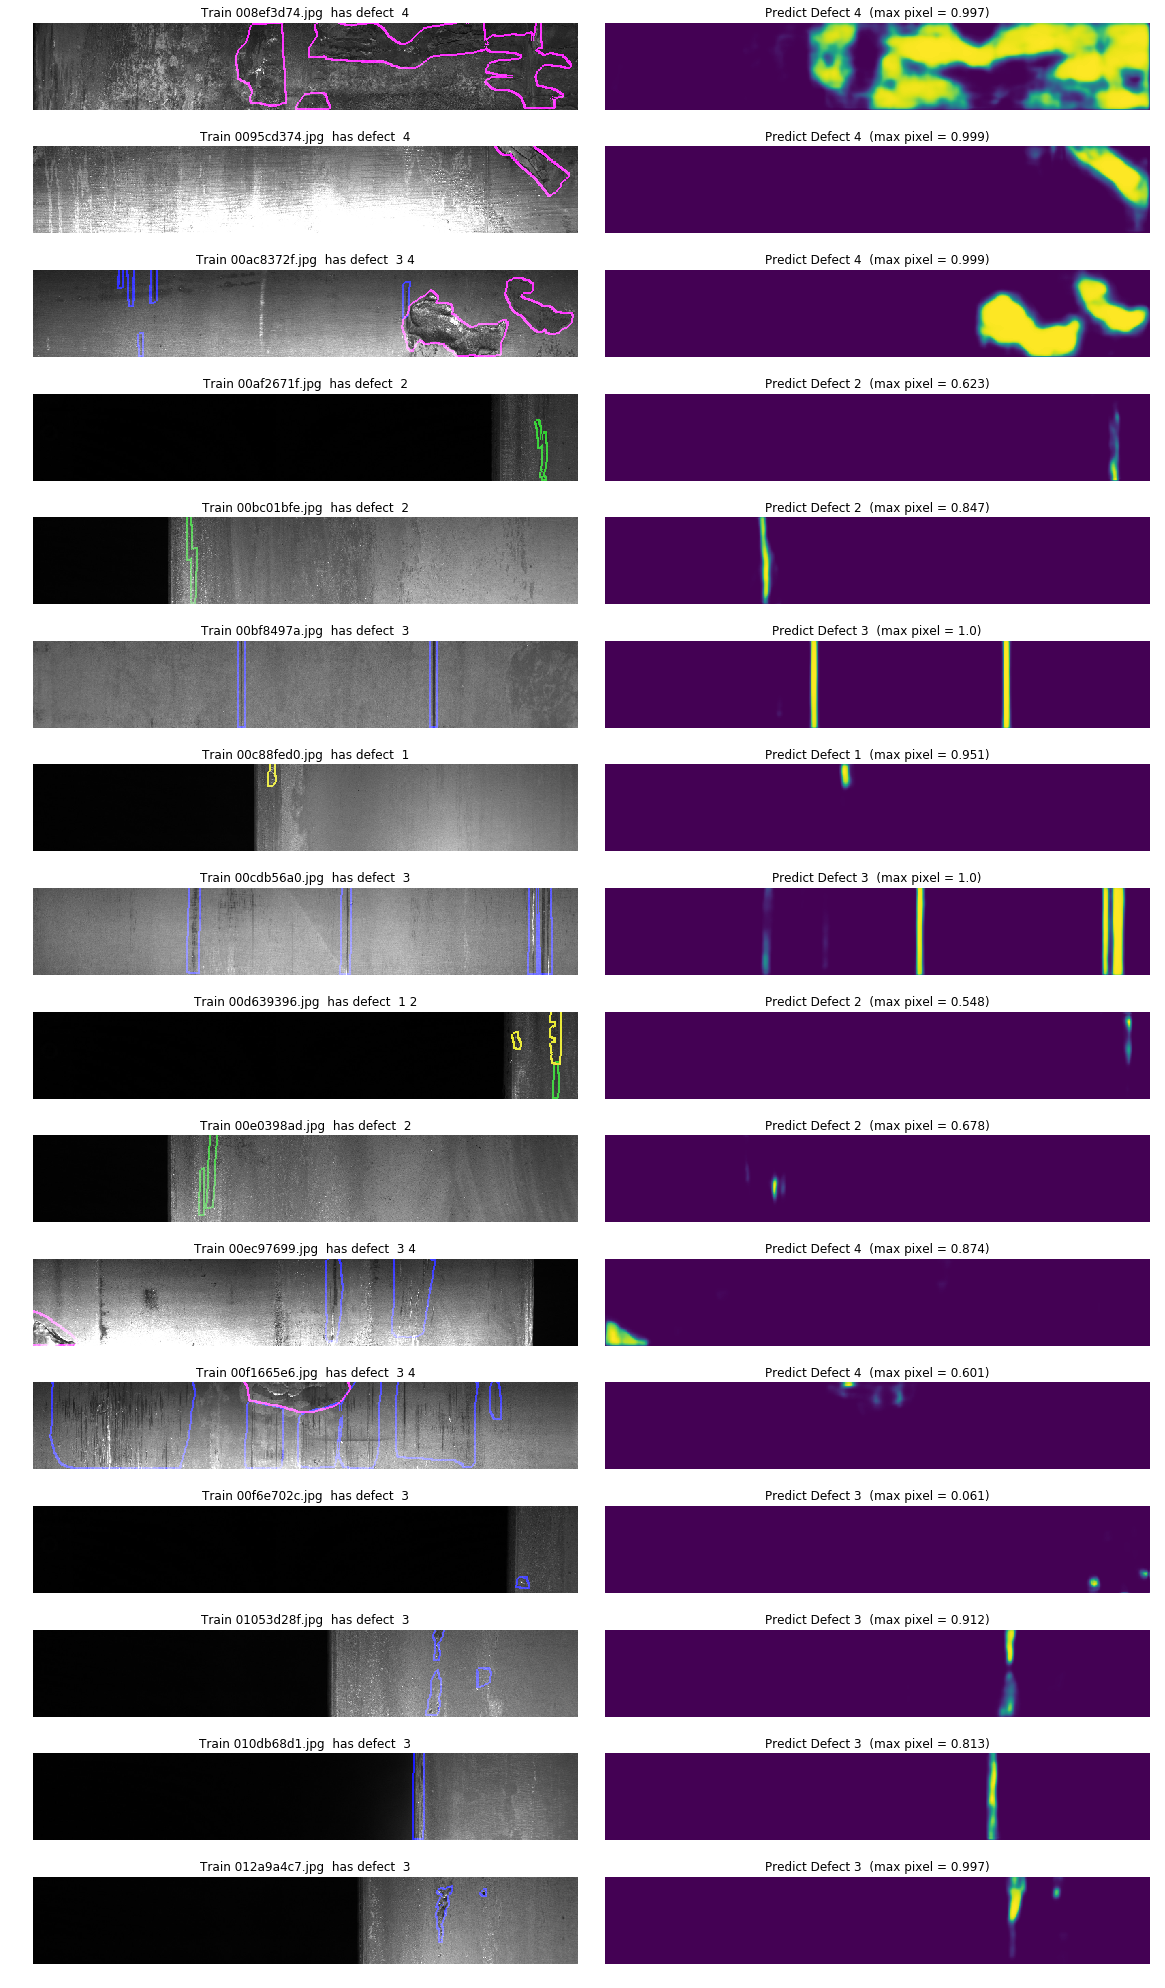

In [11]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set[val_set.index.isin(defects)])
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')

for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        extra = '  has defect '
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if np.sum(msk)!=0: 
                dft=j+1
                extra += ' '+str(j+1)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        if extra=='  has defect ': extra =''
        plt.title('Train '+train2.iloc[16*i+k,0]+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title('Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

# Error EDA 1
The masks above look pretty good. But note that we are only plotting masks corresponding to defects that are present. Below, regardless of what type of defect an image has, we will plot the defect 3 mask. Only the blue contour lines on the left are defect 3. So when we see contours on the left that do not include blue, we should not see defect 3 masks but we still do.

In [12]:
# PREDICT FROM VALIDATION SET (ONLY IMAGES WITH DEFECTS 1, 2, 4)
val_set = train2.iloc[idx:]
val_set2 = val_set[(val_set['count']!=0)&(val_set['e3']=='')].sample(16)

valid_batches = DataGenerator(val_set2,preprocess=preprocess)
preds = model.predict_generator(valid_batches,verbose=1)

1/1 [==============================] - 0s 241ms/step


Plotting predictions...
KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4


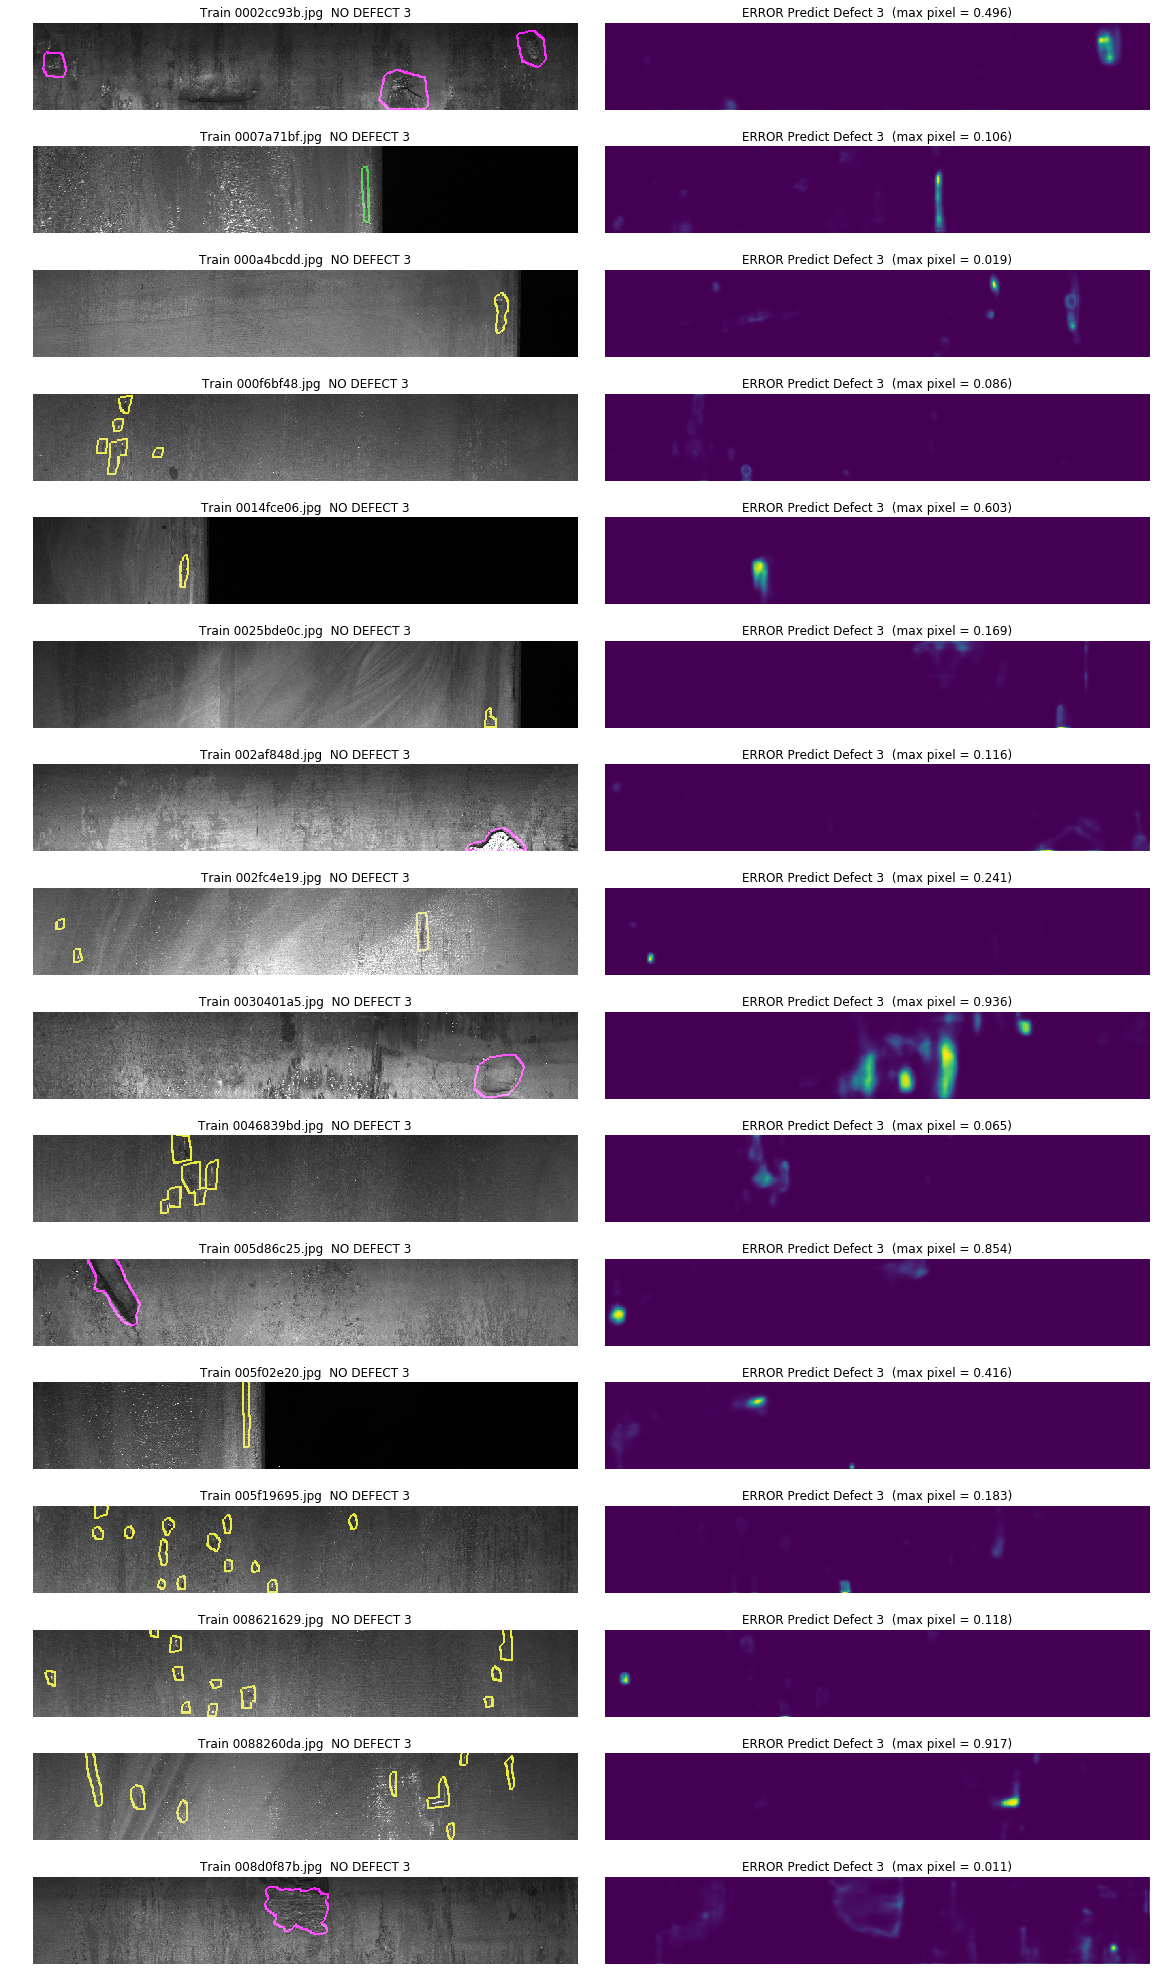

In [13]:
# PLOT PREDICTIONS
valid_batches = DataGenerator(val_set2)
print('Plotting predictions...')
print('KEY: yellow=defect1, green=defect2, blue=defect3, magenta=defect4')
for i,batch in enumerate(valid_batches):
    plt.figure(figsize=(20,36))
    for k in range(16):
        plt.subplot(16,2,2*k+1)
        img = batch[0][k,]
        img = Image.fromarray(img.astype('uint8'))
        img = np.array(img)
        dft = 0
        three = False
        for j in range(4):
            msk = batch[1][k,:,:,j]
            if (j==2)&(np.sum(msk)!=0): 
                three=np.sum(msk)
            msk = mask2pad(msk,pad=2)
            msk = mask2contour(msk,width=3)
            if j==0: # yellow
                img[msk==1,0] = 235 
                img[msk==1,1] = 235
            elif j==1: img[msk==1,1] = 210 # green
            elif j==2: img[msk==1,2] = 255 # blue
            elif j==3: # magenta
                img[msk==1,0] = 255
                img[msk==1,2] = 255
        extra = ''; extra2 = ''
        if not three: 
            extra = 'NO DEFECT 3'
            extra2 = 'ERROR '
        plt.title('Train '+train2.iloc[16*i+k,0]+'  '+extra)
        plt.axis('off') 
        plt.imshow(img)
        plt.subplot(16,2,2*k+2) 
        dft=3
        if dft!=0:
            msk = preds[16*i+k,:,:,dft-1]
            plt.imshow(msk)
        else:
            plt.imshow(np.zeros((128,800)))
        plt.axis('off')
        mx = np.round(np.max(msk),3)
        plt.title(extra2+'Predict Defect '+str(dft)+'  (max pixel = '+str(mx)+')')
    plt.subplots_adjust(wspace=0.05)
    plt.show()

# Error EDA 2
We will plot histograms showing the predicted size of each defect mask. We would hope that if an image does not have a particular defect then UNET would not predict a mask (i.e. predict less than 250 pixel mask). This is not the case. When UNET predicts a mask when a defect isn't present, we call that an "incorrect" mask. When UNET predicts a mask when a defect is present, we call that a "correct" mask. If UNET predicts less than 250 pixels, we will treat that as no mask predicted. Let's compare the distribution of "incorrect" versus "correct" masks for each defect type.

UNET outputs masks using all floating point values between 0 and 1 inclusive. When we submit to Kaggle, we need to use only integer 0 and 1. Therefore we must convert mask floating points into integers using a threshold. If `pixel>=THRESHOLD` then `pixel=1` else `pixel=0`. We will plot histograms for various thresholds below. We will consider all masks with less than 250 pixels as empty masks (where `pixel_count = 4 * pixel count` on 128x800).

From the plots below, we see that UNET doesn't create more and/or larger masks for images with defects. UNET seems to equally create masks for all images whether there is a defect or not. If we submit the output from UNET to Kaggle, our LB score will be lower than submitting all empty masks (LB 0.85674) because there are more mistake masks than correct masks. Each mistake decreases our LB score by `1/7200` and each correct increases our score by `c*(1/7200)` where `0<=c<=1` is our average dice score.

In [14]:
# PREDICT FROM VALIDATION SET (USE ALL)
valid_batches = DataGenerator(train2.iloc[idx:],preprocess=preprocess)
preds = model.predict_generator(valid_batches,verbose=1)

83/83 [==============================] - 16s 187ms/step


######################################
## Threshold = 0.1 displayed below ##
######################################


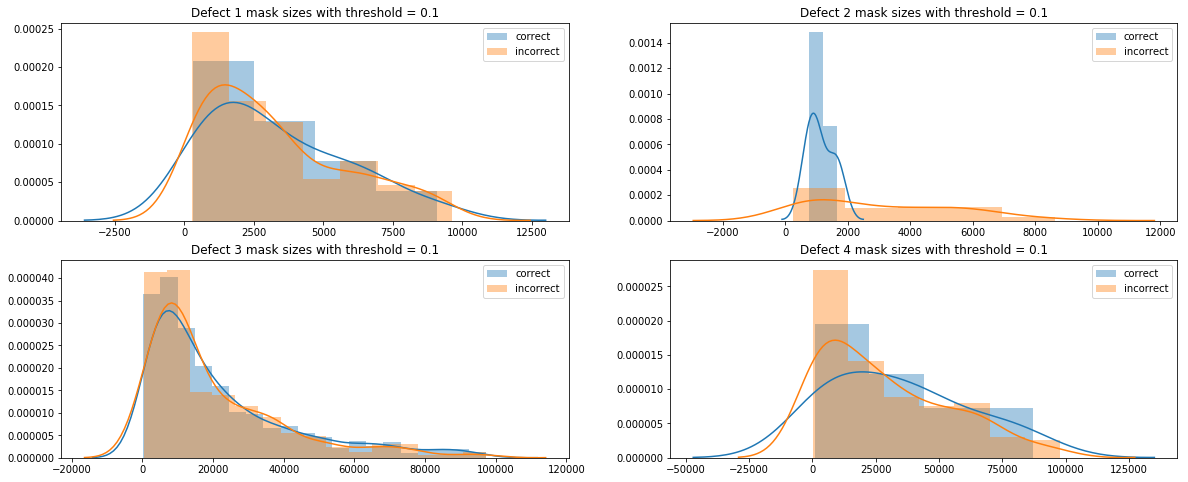

With threshold = 0.1 , defect 1 has 38 correct and 220 incorrect masks
With threshold = 0.1 , defect 2 has 3 correct and 68 incorrect masks
With threshold = 0.1 , defect 3 has 862 correct and 273 incorrect masks
With threshold = 0.1 , defect 4 has 20 correct and 172 incorrect masks

######################################
## Threshold = 0.25 displayed below ##
######################################


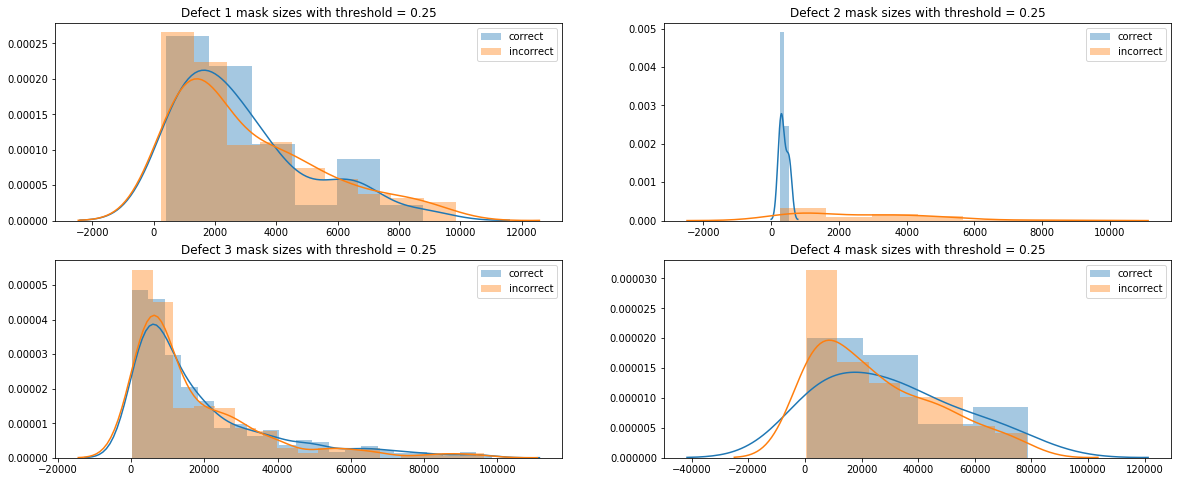

With threshold = 0.25 , defect 1 has 33 correct and 185 incorrect masks
With threshold = 0.25 , defect 2 has 3 correct and 53 incorrect masks
With threshold = 0.25 , defect 3 has 829 correct and 262 incorrect masks
With threshold = 0.25 , defect 4 has 19 correct and 161 incorrect masks

######################################
## Threshold = 0.5 displayed below ##
######################################


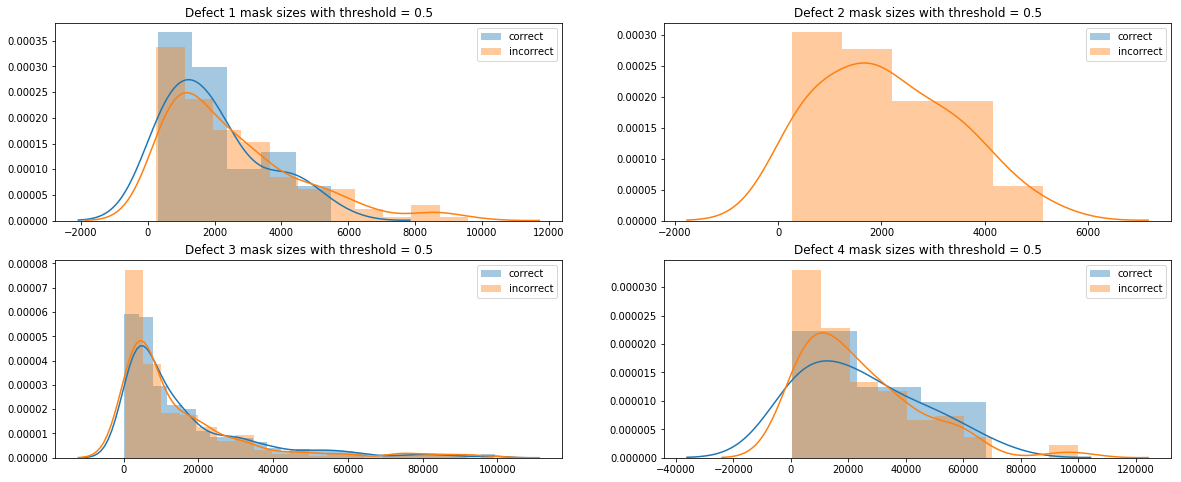

With threshold = 0.5 , defect 1 has 29 correct and 155 incorrect masks
With threshold = 0.5 , defect 2 has 0 correct and 37 incorrect masks
With threshold = 0.5 , defect 3 has 784 correct and 250 incorrect masks
With threshold = 0.5 , defect 4 has 19 correct and 144 incorrect masks

######################################
## Threshold = 0.75 displayed below ##
######################################


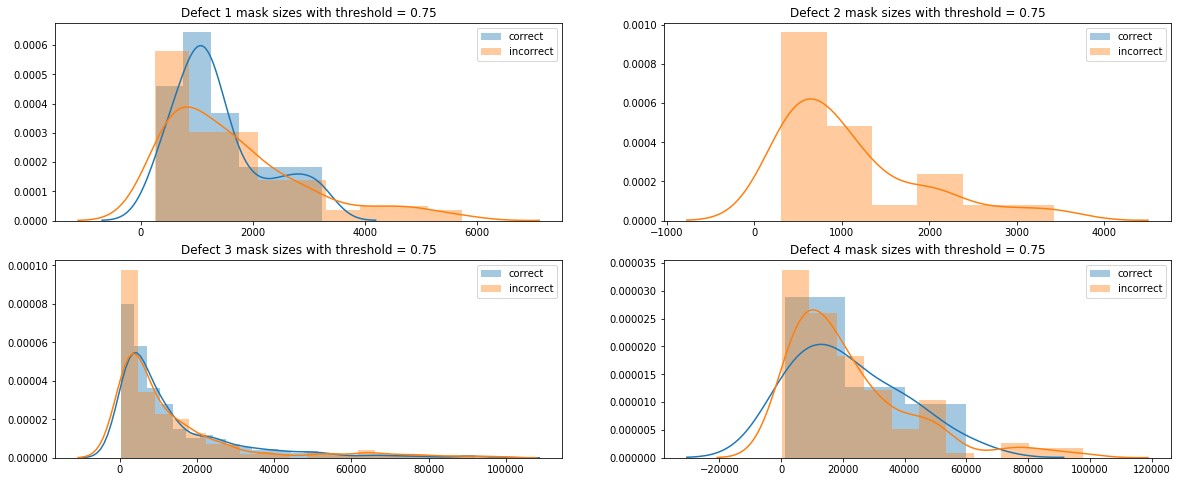

With threshold = 0.75 , defect 1 has 22 correct and 130 incorrect masks
With threshold = 0.75 , defect 2 has 0 correct and 24 incorrect masks
With threshold = 0.75 , defect 3 has 733 correct and 233 incorrect masks
With threshold = 0.75 , defect 4 has 17 correct and 133 incorrect masks

######################################
## Threshold = 0.9 displayed below ##
######################################


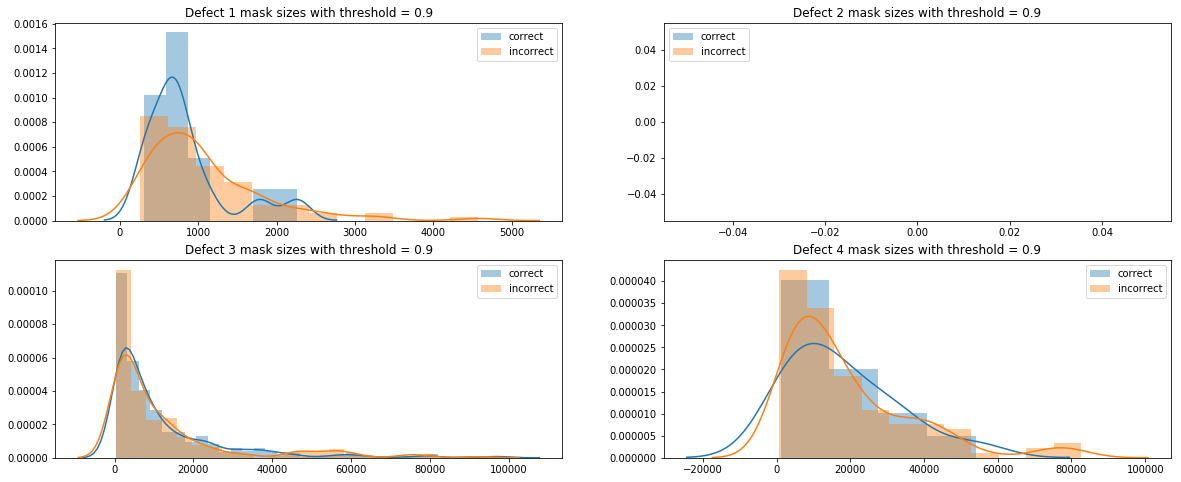

With threshold = 0.9 , defect 1 has 14 correct and 88 incorrect masks
With threshold = 0.9 , defect 2 has 0 correct and 0 incorrect masks
With threshold = 0.9 , defect 3 has 684 correct and 209 incorrect masks
With threshold = 0.9 , defect 4 has 16 correct and 124 incorrect masks



In [15]:
# PLOT RESULTS
import seaborn as sns
pix_min = 250
for THRESHOLD in [0.1, 0.25, 0.50, 0.75, 0.9]:
    print('######################################')
    print('## Threshold =',THRESHOLD,'displayed below ##')
    print('######################################')
    correct=[[],[],[],[]]; incorrect=[[],[],[],[]]
    for i,f in enumerate(train2.iloc[idx:idx+len(preds)]['ImageId']):
        preds2 = preds[i].copy()
        preds2[preds2>=THRESHOLD]=1
        preds2[preds2<THRESHOLD]=0
        sums = np.sum(preds2,axis=(0,1))
        for j in range(4):
            if 4*sums[j]<pix_min: continue
            if train2.iloc[i,j+1]=='': incorrect[j].append(4*sums[j])
            else: correct[j].append(4*sums[j])
    plt.figure(figsize=(20,8))
    for j in range(4):
        limit = [10000,10000,100000,100000][j]
        plt.subplot(2,2,j+1)
        sns.distplot([x for x in correct[j] if x<limit], label = 'correct')
        sns.distplot([x for x in incorrect[j] if x<limit], label = 'incorrect')
        plt.title('Defect '+str(j+1)+' mask sizes with threshold = '+str(THRESHOLD)); plt.legend()
    plt.show()
    for j in range(4):
        c1 = np.array(correct[j])
        c2 = np.array(incorrect[j])
        print('With threshold =',THRESHOLD,', defect',j+1,'has',len(c1[c1!=0]),'correct and',len(c2[c2!=0]),'incorrect masks')
    print()

# Submit to Kaggle
In order to make a submission using Keras pretrained UNET, we'll need to save the trained model from this kernel to a private dataset. Then load the model (dataset) into another kernel, predict test, convert masks to rle, and submit csv to Kaggle. The second kernel will have internet turned off and execute under an hour thus satisying the comp rules.

All the test masks are large for RAM. 7200 masks where each is 256x1600 of 4 byte floats is 11 Gigabyes!! (128x800 are 3 Gb) So we should be careful not to overflow memory. It's best to predict one batch, convert the masks to rle, add the rle to a dataframe, then delete the masks before predicting another batch. Below we save model, load model, and predict 1 batch as an example.

In this kernel, we saw that UNET erroneously predicts masks when no defect is present. This hurts our LB score. We'll need to design a way to set masks to empty if no defect is present. Good luck, have fun!!

[1]: https://www.kaggle.com/xhlulu/severstal-simple-2-step-pipeline

In [16]:
# SAVE MODEL
model.save('UNET.h5')

# LOAD MODEL
from keras.models import load_model
model = load_model('UNET.h5',custom_objects={'dice_coef':dice_coef})

# PREDICT 1 BATCH TEST DATASET
test = pd.read_csv(path + 'sample_submission.csv')
#test['ImageId'] = test['ImageId_ClassId'].map(lambda x: x.split('_')[0])
test_batches = DataGenerator(test.iloc[::4],subset='test',batch_size=256,preprocess=preprocess)
test_preds = model.predict_generator(test_batches,steps=1,verbose=1)

# NEXT CONVERT MASKS TO RLE, ADD TO CSV, PROCESS REMAINING BATCHES, AND SUBMIT !!

1/1 [==============================] - 11s 11s/step
